# Import and Initialize

In [1]:
import sys
print("System Path:",sys.path)

import itertools
import math

import gsd.hoomd
import hoomd

import numpy as np

from hoomd.example_plugin.update import example

import hoomd.respa_plugin
print("Plugin Path: {}".format(hoomd.respa_plugin.__file__))

import os

import random as rand

from matplotlib import pyplot

hoomd.context.initialize('--mode=cpu');#'--notice-level=5');

System Path: ['/mnt/c/Users/rocki/Documents/WORK-Chicago/pythonTest', '/home/ndbarrett/miniconda3/envs/chicago/lib/python39.zip', '/home/ndbarrett/miniconda3/envs/chicago/lib/python3.9', '/home/ndbarrett/miniconda3/envs/chicago/lib/python3.9/lib-dynload', '', '/home/ndbarrett/miniconda3/envs/chicago/lib/python3.9/site-packages']
Importing RESPA plugin. (8/15/2022 11:19PM)
Plugin Path: /home/ndbarrett/miniconda3/envs/chicago/lib/python3.9/site-packages/hoomd/respa_plugin/__init__.py
HOOMD-blue v2.9.7-4-g9e74d5e23 DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 07/18/22
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


# Generate Snapshot

In [2]:
Lx = 10
Ly = 10
Lz = 30

numParticles = 2

types = [
    "TypeA",
    "TypeB"
]

snapshot = hoomd.data.make_snapshot(N=numParticles, particle_types=types, box=hoomd.data.boxdim(Lx,Ly,Lz))

dx = 1

xs = np.linspace(-1 * numParticles/2 * dx,numParticles/2*dx,numParticles)

positions = []

for i in range(numParticles):
    positions.append([xs[i],0,0])
    
#positions[2][1] = 0.1

velocities = []

for i in range(numParticles):
    velocities.append((0,0,0))

    
particleTypes = ["TypeA","TypeB","TypeA","TypeB","TypeA"]

for i in range(len(positions)):
    snapshot.particles.position[i] = positions[i]
    snapshot.particles.velocity[i] = velocities[i]
    snapshot.particles.typeid[i] = types.index(particleTypes[i])

# Initialize Simulation

In [3]:
system = hoomd.init.read_snapshot(snapshot)
file = hoomd.dump.gsd("3_body_trajectory.gsd", period=500, group=hoomd.group.all(), overwrite=True)
neighList = hoomd.md.nlist.cell()

# lj1 = hoomd.respa_plugin.respa_pair.respa_lj(r_cut=3.0,nlist=neighList,group=hoomd.group.tags(0,2))
# lj1.pair_coeff.set('TypeA','TypeA',epsilon=1.0,sigma=1.0)
# hoomd.respa_plugin.respa_integrator.mode_respa(0.005,[[lj1,1]])

lj1 = hoomd.md.pair.lj(r_cut=3.0, nlist=neighList)
lj1.pair_coeff.set('TypeA','TypeA',epsilon=0.0,sigma=0.0)
lj1.pair_coeff.set('TypeB','TypeB',epsilon=0.0,sigma=0.0)
lj1.pair_coeff.set('TypeA','TypeB',epsilon=1.0,sigma=1.0)


integrator = hoomd.respa_plugin.respa_integrator.mode_respa(1e-4,[[lj1,1]])
# integrator = hoomd.md.integrate.mode_standard(dt=1e-4)
# hoomd.md.integrate.nve(group=hoomd.group.tags(0,numParticles-1))

log1 = hoomd.analyze.log(filename="3_body_log.log",
                         quantities=['num_particles',
                                     'ndof',
                                     'translational_ndof',
                                     'rotational_ndof',
                                     'potential_energy',
                                     'kinetic_energy',
                                     'translational_kinetic_energy',
                                     'rotational_kinetic_energy',
                                     'temperature',
                                     'pressure',
                                     'pair_lj_energy'],
                         period=100,
                         overwrite=True);

notice(2): Group "all" created containing 2 particles
FORCE TYPES: <class 'hoomd.md._md.PotentialPairLJ'> <class 'hoomd.md.pair.lj'>


# Run Simulation

In [4]:
hoomd.run(1000000)

#Try somthing with 5 beads and some bonds in them


notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 2
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:02 | Step 1000000 / 1000000 | TPS 385386 | ETA 00:00:00
Average TPS: 385130
---------
-- Neighborlist stats:
0 normal updates / 0 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 1 / n_neigh_avg: 0.5
shortest rebuild period: 100
-- Cell list stats:
Dimension: 2, 2, 8
n_min    : 0 / n_max: 1 / n_avg: 0.0625
** run complete **


# Output Results

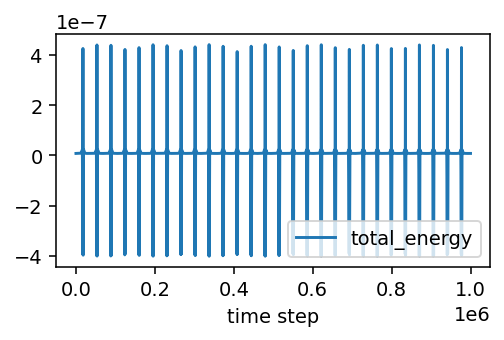

In [5]:
data = np.genfromtxt(fname='3_body_log.log', skip_header=True)
    
KE = data[:,6]
PE = data[:,5]

E = KE + PE
    
pyplot.figure(figsize=(4,2.2), dpi=140);
pyplot.plot(data[1:,0], E[1:] - np.average(E[1:]), label='total_energy');
#pyplot.title("Max KE: " + str(max(data[:,6])))
pyplot.xlabel('time step');
#pyplot.ylabel('kinetic energy');
pyplot.legend(loc='lower right');
pyplot.savefig("KEgraph.png")
pyplot.show()